In [1]:
import warnings
warnings.filterwarnings('ignore')

import os

import numpy as np
import pandas as pd

import cv2
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models.resnet import resnet50
!pip install -qq torchsummary
from torchsummary import summary

from collections import OrderedDict

from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from tqdm.notebook import tqdm
from glob import glob

seed = 42
pd.set_option('display.max_colwidth', None)

In [2]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Currently using "{device.upper()}" device.')

Currently using "CUDA" device.


In [3]:
IMAGE_SIZE = 224
batch_size = 32

mask_directory = "/kaggle/input/makeup-lips-segmentation-28k-samples/set-lipstick-original/mask/"
image_directory = "/kaggle/input/makeup-lips-segmentation-28k-samples/set-lipstick-original/720p/"

EPOCHS = 10

In [4]:
train_transforms = A.Compose([
                      A.OneOf([A.HueSaturationValue(hue_shift_limit=0.2, 
                                                    sat_shift_limit=0.2, 
                                                    val_shift_limit=0.2, 
                                                    p=0.2),      
                      A.RandomBrightnessContrast(brightness_limit=0.2, 
                                                 contrast_limit=0.2, 
                                                 p=0.9)],p=0.4),
                      A.OneOf(
                              [A.HorizontalFlip(p=0.5),
                               A.VerticalFlip(p=0.5),
                               A.RandomRotate90(p=0.5),
                               A.Transpose(p=0.5),
                               A.RandomCrop(IMAGE_SIZE, IMAGE_SIZE, p=0.5),
                              ], p=0.5),
                      A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1),
                      A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
                      ToTensorV2(p=1.0),
                      ], p=1.0)

valid_transforms = A.Compose([
                      A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1),
                      A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
                      ToTensorV2(p=1.0),
                      ], p=1.0)

invTrans = A.Compose([A.Normalize(mean=[ 0., 0., 0. ],
                                  std=[ 1/0.229, 1/0.224, 1/0.225 ], max_pixel_value=1.0),
                      A.Normalize(mean=[ -0.485, -0.456, -0.406 ],
                                  std=[ 1., 1., 1. ], max_pixel_value=1.0),
                      ], p=1.0)

def inverse_transforms(tensor):
    if tensor.size(0) == 1 and len(tensor.shape) == 4:
        tensor.squeeze_(0)
    sample = {"image": tensor.cpu().detach().numpy().transpose(1,2,0)}
    image = invTrans(**sample)["image"]

    return image

**Dataset / Dataloader**

In [5]:
df = pd.read_csv("/kaggle/input/makeup-lips-segmentation-28k-samples/set-lipstick-original/list.csv")
df.rename(columns={"filename": "image"}, inplace=True)

df["image"] = image_directory + df["image"]
df["mask"] = mask_directory + df["mask"]

In [6]:
image_paths = [str(path) for path in glob(image_directory + "*.jpg")]
mask_paths = [str(path) for path in glob(mask_directory + "*.png")]

indexes = df[~df["mask"].isin(mask_paths)].index
df.drop(indexes, inplace=True)

In [7]:
x_train, x_valid = train_test_split(df, test_size=1500, shuffle=True, random_state=seed)
x_test, x_valid = train_test_split(x_valid, train_size=0.2, shuffle=True, random_state=seed)
x_train = x_train.reset_index(drop=True)
x_valid = x_valid.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)

print(f"Train size: {x_train.shape[0]}, validation size: {x_valid.shape[0]}, test size: {x_test.shape[0]}")

Train size: 27040, validation size: 1200, test size: 300


In [22]:
mask = Image.open("/kaggle/input/makeup-lips-segmentation-28k-samples/set-lipstick-original/mask/mask00000001.png")
mask.size

(1280, 720)

In [67]:
class LipDataset(Dataset):
    def __init__(self, data, transforms):
        self.data = data
        self.transforms = transforms
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, ix):
        row = self.data.loc[ix].squeeze()
        image = Image.open(row["image"])
        image = np.array(image)
        
        mask = Image.open(row["mask"])
        mask = np.array(mask)
        if len(mask.shape) > 2:
            mask = mask[:,:,1]
        
        mask = np.where(mask > 127, 255, 0)
        
        sample = {"image": image, "mask": mask}
        sample = self.transforms(**sample)
        
        image, mask = sample["image"], sample["mask"]
        mask = mask[None, ...]
        
        return image, mask / 255.
    
    def collate_fn(self, batch):
        images, masks = list(zip(*batch))
        images, masks = [[tensor[None].to(device) for tensor in btc] for btc in [images, masks]]
        images, masks = [torch.cat(tensors) for tensors in [images, masks]]
        return images, masks

In [68]:
train_ds = LipDataset(x_train, train_transforms)
valid_ds = LipDataset(x_valid, valid_transforms)
test_ds = LipDataset(x_test, valid_transforms)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=train_ds.collate_fn)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, collate_fn=valid_ds.collate_fn)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=test_ds.collate_fn)

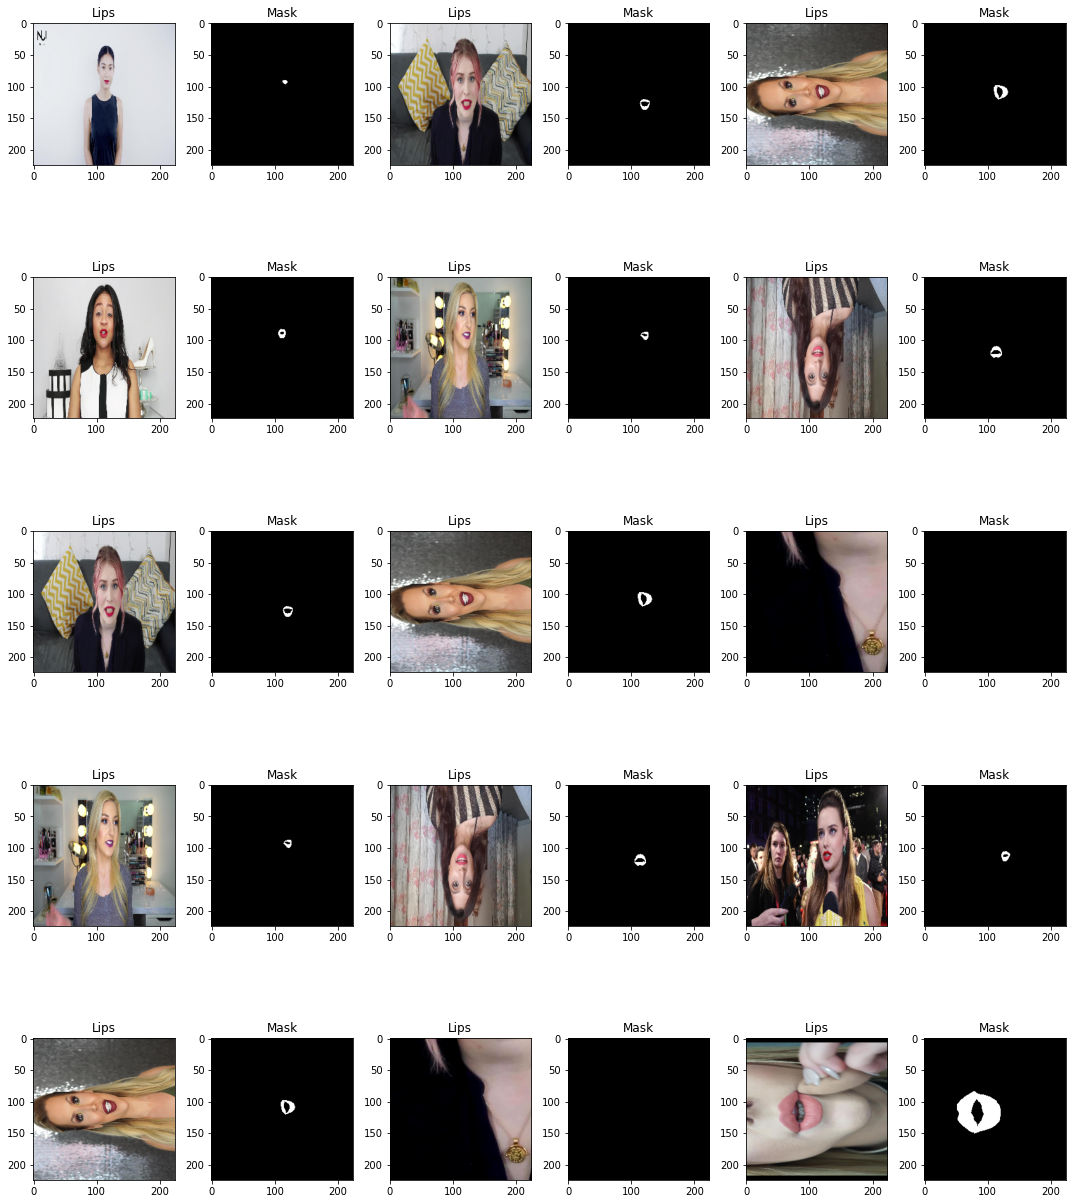

In [69]:
images, masks = next(iter(train_dl))

nrows, ncols = images.size(0)//6, 6
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(nrows*3, ncols*3))
for i in range(nrows):
    for j in range(0, ncols, 2):
        if j % 2 == 0:
            ax[i, j].set_title("Lips")
            image = images[i+j, ...]
            image = inverse_transforms(image)
            mask = masks[i+j, ...]
            mask = mask.detach().cpu().numpy().squeeze(0)
            ax[i, j].imshow(image)
            ax[i, j+1].set_title("Mask")
            ax[i, j+1].imshow(mask, cmap="gray")
plt.tight_layout()
plt.show()

**Model**

In [11]:
class IntermediateLayerGetter(nn.ModuleDict):
    """
    Simplified version of layer eraser from:
    https://github.com/VainF/DeepLabV3Plus-Pytorch
    """
    def __init__(self, model, return_layers):
        if not set(return_layers).issubset([name for name, _ in model.named_children()]):
            raise ValueError("provided layers are not present in model")

        orig_return_layers = return_layers
        return_layers = {k: v for k, v in return_layers.items()}
        layers = OrderedDict()
        for name, module in model.named_children():
            layers[name] = module
            if name in return_layers:
                del return_layers[name]
            if not return_layers:
                break

        super(IntermediateLayerGetter, self).__init__(layers)
        self.return_layers = orig_return_layers

    def forward(self, x):
        out = OrderedDict()
        for name, module in self.named_children():
            x = module(x)
            if name in self.return_layers:
                out_name = self.return_layers[name]
                out[out_name] = x
        return out

backbone = resnet50(pretrained=True)
backbone = IntermediateLayerGetter(backbone, {'layer1': 'casual_branch', 'layer3': 'atrous_branch'})

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [12]:
class ConvBlock(nn.Module):
    def __init__(self, num_filters=1024, 
                       out_filters=None,
                       kernel_size=3, 
                       dilation=1, 
                       padding=1, 
                       bias=False, **kwargs):
        super(ConvBlock, self).__init__(**kwargs)
        padding = dilation if dilation > 1 else 0
        out_filters = num_filters if out_filters is None else out_filters
        self.block = nn.Sequential(
                        nn.Conv2d(num_filters, out_filters, kernel_size, dilation=dilation, padding=padding, bias=bias),
                        nn.BatchNorm2d(out_filters),
                        nn.ReLU()
            )
        
    def forward(self, x):
        return self.block(x)
    
class DilatedSPP(nn.Module):
    def __init__(self, num_filters=1024, **kwargs):
        super(DilatedSPP, self).__init__(**kwargs)
        
        self.issued = ConvBlock(num_filters, num_filters // 4, kernel_size=1, bias=True)  # ?
        num_filters //= 4  # ?
        
        self.conv_in = ConvBlock(num_filters, num_filters, kernel_size=1, bias=True)
        
        self.conv_1 = ConvBlock(num_filters, kernel_size=1, dilation=1)
        self.conv_2 = ConvBlock(num_filters, kernel_size=3, dilation=6)
        self.conv_3 = ConvBlock(num_filters, kernel_size=3, dilation=12)
        self.conv_4 = ConvBlock(num_filters, kernel_size=3, dilation=18)
        
        self.out_conv = ConvBlock(num_filters*5, num_filters, kernel_size=1)
    
    def forward(self, x):
        dims = x.size()
        x = self.issued(x)
        
        x1 = F.avg_pool2d(x, kernel_size=(dims[-2], dims[-1]))
        x1 = self.conv_in(x1)
        upsample = (dims[2] // x1.size(2), dims[3] // x1.size(3))
        out_pool = F.interpolate(x1, scale_factor=upsample, mode="bilinear")
        
        out_1 = self.conv_1(x)
        out_6 = self.conv_2(x)
        out_12 = self.conv_3(x)
        out_18 = self.conv_4(x)

        out = torch.cat([out_pool, out_1, out_6, out_12, out_18], dim=1)
        out = self.out_conv(out)
        
        return out

In [13]:
class DeepLabV3(nn.Module):
    def __init__(self, backbone, num_classes=3, freeze=False, **kwargs):
        super(DeepLabV3, self).__init__(**kwargs)
        self.backbone = backbone
        if freeze:
            for p in self.backbone.parameters():
                p.requires_grad = False
        self.spp = DilatedSPP()
        self.issued = ConvBlock(256, 48, kernel_size=1)
        
        self.conv1 = ConvBlock(304, 256)
        self.conv2 = ConvBlock(256)
        self.final = nn.Conv2d(256, num_classes, kernel_size=1)
        
        self._init_weights()
        
    def forward(self, x):
        _, _, h, w = x.size()
        
        backout = self.backbone(x)
        x_a, x_b = backout["casual_branch"], backout["atrous_branch"]
        x_b = self.spp(x_b)
        x_b = F.interpolate(x_b, scale_factor=(h // 4 // x_b.size(2), w // 4 // x_b.size(3)), mode="bilinear")
        
        x_a = self.issued(x_a)
        
        x = torch.cat([x_a, x_b], dim=1)
        x = self.conv1(nn.ZeroPad2d((1,1,1,1))(x))
        x = self.conv2(nn.ZeroPad2d((1,1,1,1))(x))
        
        x = F.interpolate(x, scale_factor=(h // x.size(2), w // x.size(3)), mode="bilinear")
        x = self.final(x)

        return x
    
    def _init_weights(self):
        for n, m in self.named_modules():
            if n.startswith("backbone"):
                continue
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

In [71]:
def calc_iou(inputs, targets, smooth=1e-8):
    """
    Binary target metric:
    inputs: [B, 1, H, W]
    targets: [B, 1, H, W]
    """
    inputs = F.sigmoid(inputs)       

    inputs = inputs.view(-1)
    targets = targets.view(-1)

    intersection = (inputs * targets).sum()
    total = (inputs + targets).sum()
    union = total - intersection 

    return (intersection + smooth)/(union + smooth)

def train_one_batch(data, model, optimizer, criterion, threshold=0.5, pos_only=False):
    model.train()
    images, masks = data
    
    optimizer.zero_grad()
    out = model(images)
    
    loss = criterion(out, masks)

    loss.backward()
    optimizer.step()

    mask_iou = calc_iou(out, masks)
    
    return loss.item(), mask_iou.item()

@torch.no_grad()
def validate_one_batch(data, model, criterion):
    model.eval()
    images, masks = data
    out = model(images)
    
    loss = criterion(out, masks)
        
    mask_iou = calc_iou(out, masks)
    
    return loss.item(), mask_iou.item()

@torch.no_grad()
def test_plot(model, threshold=0.5):
    model.eval()
    idx = np.random.randint(len(x_test))
    image = Image.open(x_test.iloc[idx, 0]).resize((IMAGE_SIZE, IMAGE_SIZE))
    image = np.array(image)
    sample = {"image": image}
    inputs = valid_transforms(**sample)["image"].unsqueeze(0).to(device)
    
    mask = Image.open(x_test.iloc[idx, -1]).resize((IMAGE_SIZE, IMAGE_SIZE))
    mask = np.array(mask)
    if len(mask.shape) < 3:
        mask = np.array(mask)[..., np.newaxis]
        mask = np.repeat(mask, 3, axis=-1)
    else:
        mask = np.array(mask)
    masked_image = cv2.addWeighted(image, 0.5, mask, 0.5, 0)
    
    out = model(inputs)
    out = torch.sigmoid(out)  # torch.argmax(out, 1) -> out.repeat(3).map(color_palette)
    out = out.detach().cpu().numpy()[0].transpose(1,2,0)
    out = np.where(out >= threshold, 1, 0)
    out = np.clip(out * 255, 0, 255)
    out = np.repeat(out, 3, axis=-1).astype(np.uint8)

    out_image = cv2.addWeighted(image, 0.5, out, 0.5, 0)
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,5))
    axes[0].imshow(image)
    axes[0].set_title("Image")
    axes[1].imshow(masked_image)
    axes[1].set_title("Original Mask")
    axes[2].imshow(out_image)
    axes[2].set_title("Predicted Mask")
    plt.tight_layout()
    plt.show()

In [15]:
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0, path='model.pth'):
        self.path = path
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model=None):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            checkpoint = {
                'model': model,
            }
            torch.save(checkpoint, self.path)
            print(f'Model saved to: {self.path}')
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [16]:
ALPHA = 0.25
GAMMA = 2.0
BETA = 0.75

class FocalTverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalTverskyLoss, self).__init__()
        self.weight = weight
        self.size_average = size_average  # redundant

    def forward(self, inputs, targets, smooth=1e-8, alpha=ALPHA, beta=BETA, gamma=GAMMA):
        
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1 - targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
        
        Tversky = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)  
        FocalTversky = (1 - Tversky)**gamma
                       
        return FocalTversky

In [17]:
model = DeepLabV3(backbone, num_classes=1).to(device)

criterion = nn.BCEWithLogitsLoss()
# criterion = FocalTverskyLoss()

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=0.0001, betas=(0.9, 0.999), weight_decay=0.0005)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, min_lr=1e-7, factor=0.5)
stopper = EarlyStopping(patience=4)

In [18]:
import time

print_freq = 100

for epoch in range(1, EPOCHS+1):

    train_loss, train_accs = [], []
    for step, batch in enumerate(train_dl):
        time_1 = time.time()
        
        loss, accuracy = train_one_batch(batch, model, optimizer, criterion)

        train_loss.append(loss)
        train_accs.append(accuracy)
        
        if step % print_freq == 0:
            print('epoch:', epoch, 
                  '\tstep:', step+1, '/', len(train_dl),
                  '\ttrain loss:', '{:.4f}'.format(loss),
                  '\ttrain IoU:','{:.4f}'.format(accuracy),
                  '\ttime:', '{:.4f}'.format((time.time()-time_1)*print_freq), 's')
    
    valid_loss, valid_accs = [], []
    for step, batch in enumerate(tqdm(valid_dl)):
        loss, accuracy = validate_one_batch(batch, model, criterion)
        
        valid_loss.append(loss)
        valid_accs.append(accuracy)
        
    print('epoch:', epoch, '/', EPOCHS,
          '\ttrain loss:', '{:.4f}'.format(np.mean(train_loss)),
          '\tvalid loss:', '{:.4f}'.format(np.mean(valid_loss)),
          '\ttrain IoU', '{:.4f}'.format(np.mean(train_accs)),
          '\tvalid IoU', '{:.4f}'.format(np.mean(valid_accs)))
    
    test_plot(model)
    
    stopper(np.mean(valid_loss), model)
    scheduler.step(np.mean(valid_loss))

epoch: 1 	step: 1 / 845 	train loss: 0.3843 	train IoU: 0.0034 	time: 1675.9542 s
epoch: 1 	step: 201 / 845 	train loss: 0.0147 	train IoU: 0.1725 	time: 73.9224 s
epoch: 1 	step: 401 / 845 	train loss: 0.0097 	train IoU: 0.3629 	time: 73.5420 s


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

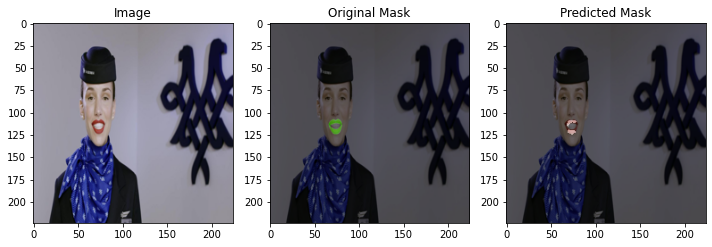

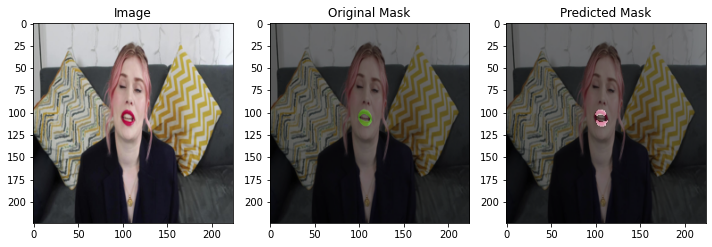

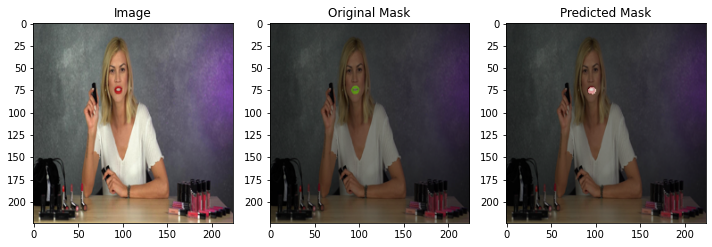

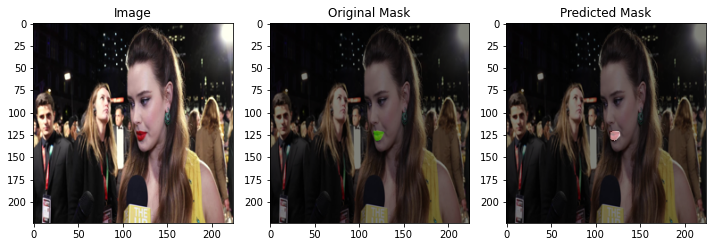

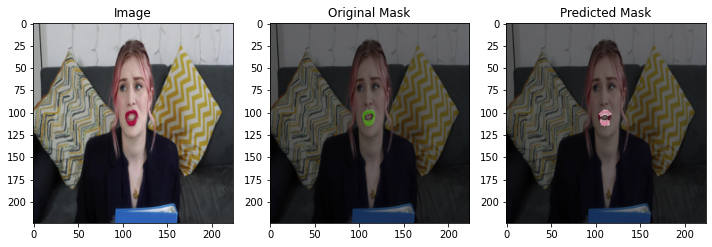

In [73]:
for _ in range(5):
    test_plot(model)